In [2]:
import pandas as pd
import json
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel, BertTokenizer
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
data = []
with open('ratebeer.json', 'r') as f:
  for l in f:
	  d = eval(l)
	  data.append(d)

df = pd.DataFrame(data)

In [4]:
# Function to convert fractional scores to numerical values
def convert_fraction_to_numeric(fraction):
	try:
		num, denom = map(int, fraction.split('/'))
		return num
	except:
		return None

score_columns = ['review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'review/overall']
for col in score_columns:
	df[col] = df[col].apply(convert_fraction_to_numeric)

# Convert ABV to float
df['beer/ABV'] = pd.to_numeric(df['beer/ABV'], errors='coerce')

# Convert review/time to datetime
df['review/time'] = pd.to_datetime(df['review/time'], unit='s', errors='coerce')

# Convert categorical columns to category dtype
categorical_columns = ['beer/name', 'beer/style', 'review/profileName']
for col in categorical_columns:
	df[col] = df[col].astype('category')

/tmp/ipykernel_2323020/2561930615.py:17: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['review/time'] = pd.to_datetime(df['review/time'], unit='s', errors='coerce')


In [5]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
len(df)

2785522

In [6]:
df.isna().sum()

beer/name             0
beer/beerId           0
beer/brewerId         0
beer/ABV              0
beer/style            0
review/appearance     0
review/aroma          0
review/palate         0
review/taste          0
review/overall        0
review/time           0
review/profileName    0
review/text           0
dtype: int64

In [7]:
df.columns

Index(['beer/name', 'beer/beerId', 'beer/brewerId', 'beer/ABV', 'beer/style',
       'review/appearance', 'review/aroma', 'review/palate', 'review/taste',
       'review/overall', 'review/time', 'review/profileName', 'review/text'],
      dtype='object')

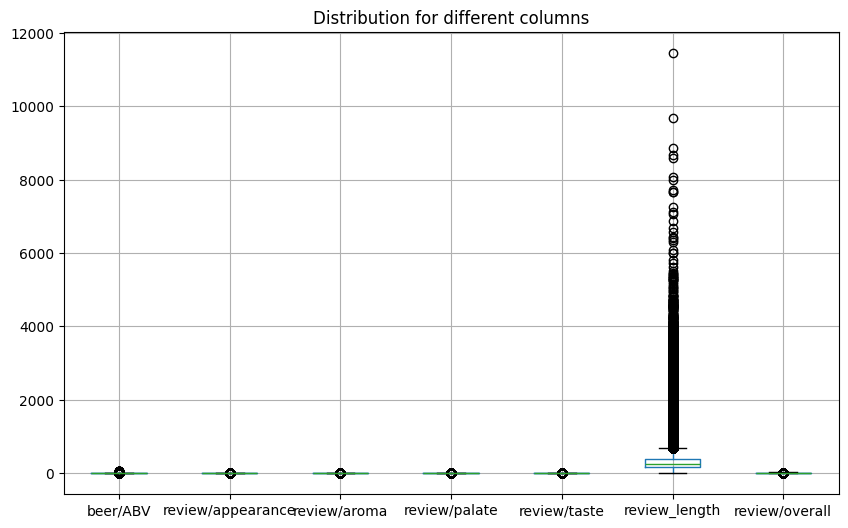

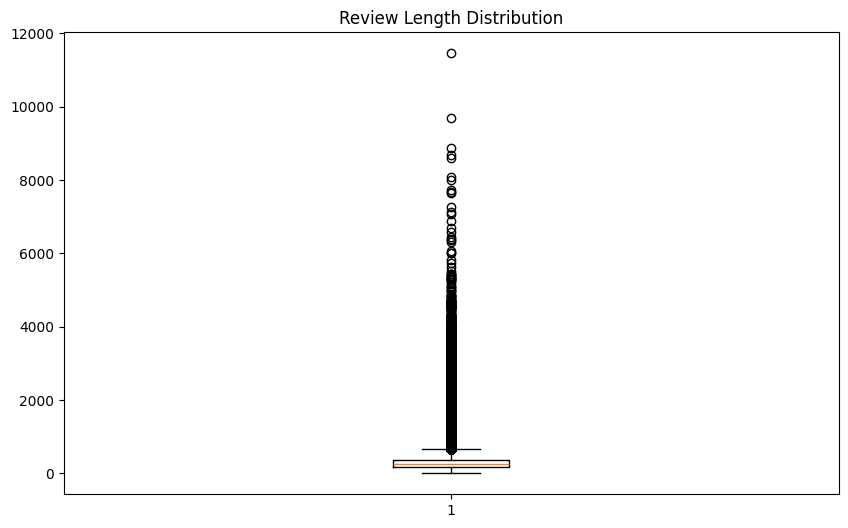

Mean Review Length: 308.3471744254757
Median Review Length: 254.0
Max Review Length: 11455
Min Review Length: 0
25th Quartile (Q1) of Review Length: 176.0
75th Quartile (Q3) of Review Length: 375.0
Lower Bound: 0
Upper Bound: 673.5
Number of Outliers: 147873
Number of Low Length Reviews: 10671


In [8]:
reviews = df['review/text'].values
review_length = [len(review) for review in reviews]
df['review_length'] = review_length

boxplot = df.boxplot(column=['beer/ABV', 'review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'review_length', 'review/overall'], figsize=(10, 6))
plt.title('Distribution for different columns')
plt.show()


figure = plt.figure(figsize=(10, 6))
plt.boxplot(review_length)
plt.title('Review Length Distribution')
plt.show()

print(f"Mean Review Length: {np.mean(review_length)}")
print(f"Median Review Length: {np.median(review_length)}")
print(f"Max Review Length: {np.max(review_length)}")
print(f"Min Review Length: {np.min(review_length)}")

q25 = np.percentile(review_length, 25)
q75 = np.percentile(review_length, 75)

print(f"25th Quartile (Q1) of Review Length: {q25}")
print(f"75th Quartile (Q3) of Review Length: {q75}")

IQR = q75 - q25
lower_bound = q25 - 1.5 * IQR 
lower_bound = 0 if lower_bound < 0 else lower_bound
upper_bound = q75 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

outliers = [length for length in review_length if length < lower_bound or length > upper_bound]
print(f"Number of Outliers: {len(outliers)}")

zero_length_reviews = [review for review in reviews if 50 >= len(review) > 0]
print(f"Number of Low Length Reviews: {len(zero_length_reviews)}")

In [9]:
df['review_length'] = review_length
df = df[(df['review_length'] > 50) & (df['review_length'] < upper_bound)]
len(df)

2622248

## Generate Subset for Analysis and prediction

In [10]:
unique_beers = df['beer/name'].nunique()
unique_reviewers = df['review/profileName'].nunique()
print(f"Unique Beers: {unique_beers}")
print(f"Unique Reviewers: {unique_reviewers}")

Unique Beers: 86397
Unique Reviewers: 27977


In [11]:
# Calculate the sampling fraction for reviewers and beers
total_samples = 550000
unique_reviewers = df['review/profileName'].nunique()
unique_beers = df['beer/name'].nunique()

samples_per_reviewer = max(1, total_samples // unique_reviewers)
samples_per_beer = max(1, total_samples // unique_beers)

# Group by reviewer and beer, sample appropriately
reviewer_samples = (
	df.groupby('review/profileName')
	.apply(lambda x: x.sample(min(len(x), samples_per_reviewer), random_state=42))
	.reset_index(drop=True)
)

beer_samples = (
	df.groupby('beer/name')
	.apply(lambda x: x.sample(min(len(x), samples_per_beer), random_state=42))
	.reset_index(drop=True)
)

# Combine both subsets, drop duplicates, and ensure the total size is capped at 500k
subset_df = pd.concat([reviewer_samples, beer_samples]).drop_duplicates().sample(
	n=min(len(reviewer_samples) + len(beer_samples), 500000),
	random_state=42
).reset_index(drop=True)

# Display results
print(f"Subset size: {len(subset_df)}")
print(f"Unique Reviewers in Subset: {subset_df['review/profileName'].nunique()}")
print(f"Unique Beers in Subset: {subset_df['beer/name'].nunique()}")

/tmp/ipykernel_2323020/1583315362.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('review/profileName')
/tmp/ipykernel_2323020/1583315362.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('beer/name')


Subset size: 500000
Unique Reviewers in Subset: 27226
Unique Beers in Subset: 84945


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

def get_sentiment(texts):
	sentiment_scores = []
	for text in tqdm(texts, desc="Predicting Sentiment"):
		inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
		outputs = model(**inputs.to(device))
		scores = torch.softmax(outputs.logits, dim=1)
		sentiment = torch.argmax(scores) + 1
		sentiment_scores.append(sentiment.item())
	
	return sentiment_scores

example_text = ["This beer is fantastic, I really enjoyed it!"]
sentiment_score = get_sentiment(example_text)
print(f"Sentiment Score: {sentiment_score}")

subset_df['sentiment_score'] = get_sentiment(list(subset_df['review/text'].values))
print(subset_df[['review/text', 'sentiment_score']].head(5))

Predicting Sentiment: 100%|██████████| 1/1 [00:00<00:00, 101.91it/s]


Sentiment Score: [5]


Predicting Sentiment: 100%|██████████| 500000/500000 [58:40<00:00, 142.04it/s] 


                                         review/text  sentiment_score
0  Draught@brewpub (Portland, OR, ABV 6.2%, 72 IB...                4
1  Tap @ Toronado SD. Pours jet black with a tiny...                4
2  My first dunkelweizen.  Medium sized head, off...                4
3  Not much here, I guess if you like light beer ...                3
4  Sampled at the Utrechts Bokbierfestival 2003: ...                3


In [ ]:
subset_df.to_csv('ratebeer_subset.csv', index=False, escapechar='\\')

/tmp/ipykernel_1975211/3012373138.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ratebeer_subset.csv')
